# Load and preprocess images

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras import optimizers

from tensorflow.keras.models import load_model

### Hyperparameters

In [3]:
batch_size = 16
# Previosly 256 - Using 224 because most of the images are just faces and it might improve the training time.
img_height = 224 # rescale width 
img_width = 224 # rescale height

In [4]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

In [5]:
import seaborn as sns

# function to plot confussion matrix. We'll use it later to display the effectiveness of our model**
def plot_confussion_matrix(labels, predictions, classes, figsize = 3):
    
    con_mat = tf.math.confusion_matrix(labels, predictions).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 3)
    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = classes, 
                         columns = classes)

    figure = plt.figure(figsize=(figsize, figsize))
    sns.heatmap(con_mat_df
                , annot=True
                , xticklabels=classes
                , yticklabels=classes
                #, cmap=plt.cm.Blues
                )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlim(-0.0, len(classes))
    plt.ylim(len(classes), -0.0)
    plt.show()

In [6]:
def plot_hist(hist):
    data = pd.DataFrame(hist.history)
    plt.plot(data)
    plt.grid(True)
    plt.legend(data.columns)
    plt.show()

In [7]:
def plot_history_train(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

### Load data using a Keras utility

In [8]:
data_dir = 'C:/Users/micha/OneDrive/Desktop/U/TFM/Data2'

#data_dir = 'C:/Users/ics/OneDrive/UNAV/TFG/Museo/wikiart_test'

In [9]:
import pathlib
data_dir = pathlib.Path(data_dir)
print(data_dir)
print(type(data_dir))

C:\Users\micha\OneDrive\Desktop\U\TFM\Data2
<class 'pathlib.WindowsPath'>


### Train and Val Split

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    color_mode="rgb",
    seed=0,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(type(train_ds))

Found 27512 files belonging to 4 classes.
Using 19259 files for training.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    color_mode="rgb",
    seed=0,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(type(val_ds))

Found 27512 files belonging to 4 classes.
Using 8253 files for validation.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [12]:
class_names = train_ds.class_names
print(class_names)

['1', '3', '4', '6']


### Sesgo

In [13]:
# Sesgo
class_weight = {'Happiness':1., 'Surprise':3., 'Fear':0.8, 'Anger':0.3}
class_weight = {0:1., 1:3., 2:0.8, 3:0.3}

In [14]:
# compruebo que he puesto bien las etiquetas con su codificación
for images, labels in val_ds.take(1):
    for i in range(9):
        print(class_names)
        print(labels)
        print(labels[i])
        print(class_names[labels[i]])

['1', '3', '4', '6']
tf.Tensor([3 3 3 1 0 3 3 0 0 2 0 3 3 0 3 2], shape=(16,), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
6
['1', '3', '4', '6']
tf.Tensor([3 3 3 1 0 3 3 0 0 2 0 3 3 0 3 2], shape=(16,), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
6
['1', '3', '4', '6']
tf.Tensor([3 3 3 1 0 3 3 0 0 2 0 3 3 0 3 2], shape=(16,), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
6
['1', '3', '4', '6']
tf.Tensor([3 3 3 1 0 3 3 0 0 2 0 3 3 0 3 2], shape=(16,), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
3
['1', '3', '4', '6']
tf.Tensor([3 3 3 1 0 3 3 0 0 2 0 3 3 0 3 2], shape=(16,), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
1
['1', '3', '4', '6']
tf.Tensor([3 3 3 1 0 3 3 0 0 2 0 3 3 0 3 2], shape=(16,), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
6
['1', '3', '4', '6']
tf.Tensor([3 3 3 1 0 3 3 0 0 2 0 3 3 0 3 2], shape=(16,), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
6
['1', '3', '4', '6']
tf.Tensor([3 3 3 1 0 3 3 0 0 2 0 3 3 0 3 2], shape=(16,), dtype=int32

### Visualize the data

Here are the first nine images from the training dataset.

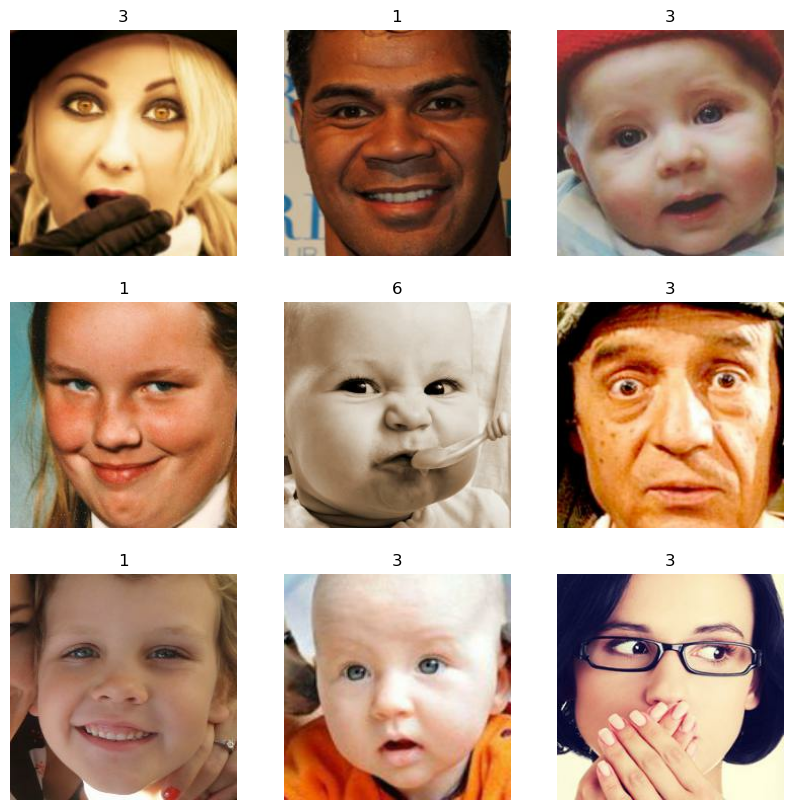

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


Batch size of 16, height and width of 224. 1 channel meaning it's on grayscale.

### Standardize the data


In the case of grayscale images, you can perform standardization by dividing the pixel values by 255 to scale them between 0 and 1, which effectively normalizes the values.

### Configure the dataset for performance

In [82]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Label Encoding

## BASE MODEL
By using MobileNet

In [58]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_19  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_49 (Dense)            (None, 4)                 4100      
                                                                 
Total params: 3,232,964
Trainable params: 4,100
Non-trainable params: 3,228,864
_________________________________________________________________


In [59]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)

Epoch 1/10
1204/1204 [==============================] - 333s 276ms/step - loss: 1.0357 - accuracy: 0.5568 - val_loss: 0.9233 - val_accuracy: 0.6141
Epoch 2/10
1204/1204 [==============================] - 341s 283ms/step - loss: 0.8913 - accuracy: 0.6298 - val_loss: 0.8942 - val_accuracy: 0.6279
Epoch 3/10
1204/1204 [==============================] - 331s 275ms/step - loss: 0.8606 - accuracy: 0.6423 - val_loss: 0.8818 - val_accuracy: 0.6331
Epoch 4/10
1204/1204 [==============================] - 338s 281ms/step - loss: 0.8417 - accuracy: 0.6531 - val_loss: 0.8955 - val_accuracy: 0.6289
Epoch 5/10
1204/1204 [==============================] - 332s 275ms/step - loss: 0.8263 - accuracy: 0.6574 - val_loss: 0.8873 - val_accuracy: 0.6347
Epoch 6/10
1204/1204 [==============================] - 326s 271ms/step - loss: 0.8150 - accuracy: 0.6653 - val_loss: 0.8924 - val_accuracy: 0.6344
Epoch 7/10
1204/1204 [==============================] - 330s 274ms/step - loss: 0.8108 - accuracy: 0.6672 - val_

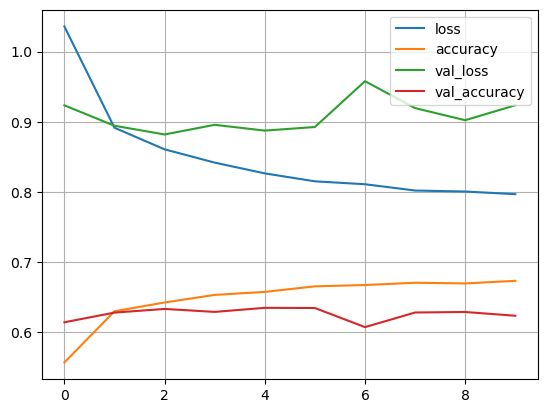

In [60]:
plot_hist(history)

516/516 [==============================] - 69s 133ms/step


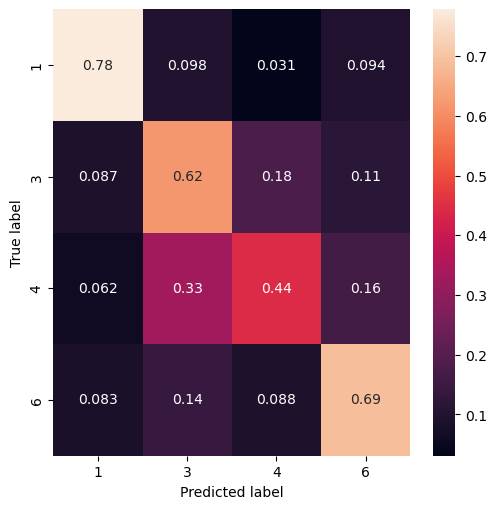

In [51]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

Promising results for being the first model! 
Observations:
There's definetely room for improvement. Hyperparameter tuning must be done.
The class 4 (Fear) is not being predicted correctly. Adding weight to that class might be a good option.

# GridSearch

# Model Tuning: WEIGHT

## Model 1. Too much weight on the surprise.

Actions taken: <br>
**Epochs** changed from 10 to 14 <br>
**Batch Size** changed from 32 to 64 <br>
**Layers** changed from 2 to 4 <br>
**Tuned** out the weights <br>

In [ ]:
# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Define the hyperparameters
hyperparameters = {
    "learning_rate": 0.001,
    "batch_size": 64,
    "num_layers": 4,
    "num_units": 512,
    "dropout_rate": 0.2
}

# Create a new model on top of the base model
model = Sequential()

# Add the input Rescaling layer
model.add(Rescaling(1./255, input_shape=input_shape))

# Add the base model
model.add(base_model)

# Add GlobalAveragePooling2D layer
model.add(GlobalAveragePooling2D())

# Add the dense layers
for _ in range(hyperparameters["num_layers"]):
    model.add(Dense(hyperparameters["num_units"], activation='relu'))
    model.add(tf.keras.layers.Dropout(hyperparameters["dropout_rate"]))

# Add the output layer
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparameters["learning_rate"]),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Save the model
model.save('Opetimized_model.h5', save_format='h5')
# Print the model summary
model.summary()


In [ ]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=14,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 3.0, 3: 1.0},
)
plot_hist(history)

In [ ]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

Conclusions: <br>
Surprise and anger got worse, however it seems like the accuracy with Happiness and surprise improved. Specially surprise. I'll tune down the weight to see if it improves. <br>
The number of epochs seem to have an impact in the model and increasing it might have a bigger impact. <br>

## Model 2. Pending.

Actions taken: <br>
**Epochs** increased from 14 to 16 <br>
**Batch Size** reduced from 64 to 32 <br>
**Tuned** out the weights (Surprise decreased from 3.0 to 1.5) <br>

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))



# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Define the hyperparameters
hyperparameters = {
    "learning_rate": 0.001,
    "batch_size": 32,
    "num_layers": 4,
    "num_units": 512,
    "dropout_rate": 0.2
}

# Create a new model on top of the base model
model = Sequential()

# Add the input Rescaling layer
model.add(Rescaling(1./255, input_shape=input_shape))

# Add the base model
model.add(base_model)

# Add GlobalAveragePooling2D layer
model.add(GlobalAveragePooling2D())

# Add the dense layers
for _ in range(hyperparameters["num_layers"]):
    model.add(Dense(hyperparameters["num_units"], activation='relu'))
    model.add(tf.keras.layers.Dropout(hyperparameters["dropout_rate"]))

# Add the output layer
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparameters["learning_rate"]),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Save the model
model.save('Optimized_model2.h5', save_format='h5')
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)              

Epoch 1/16
1204/1204 [==============================] - 240s 199ms/step - loss: 1.2116 - accuracy: 0.2501 - val_loss: 0.9929 - val_accuracy: 0.1710
Epoch 2/16
1204/1204 [==============================] - 238s 198ms/step - loss: 1.0776 - accuracy: 0.2592 - val_loss: 0.9343 - val_accuracy: 0.2308
Epoch 3/16
1204/1204 [==============================] - 226s 188ms/step - loss: 1.0284 - accuracy: 0.2599 - val_loss: 0.9145 - val_accuracy: 0.2295
Epoch 4/16
1204/1204 [==============================] - 223s 185ms/step - loss: 1.0005 - accuracy: 0.2612 - val_loss: 0.9173 - val_accuracy: 0.2404
Epoch 5/16
1204/1204 [==============================] - 226s 188ms/step - loss: 0.9687 - accuracy: 0.2551 - val_loss: 0.9040 - val_accuracy: 0.2426
Epoch 6/16
1204/1204 [==============================] - 225s 187ms/step - loss: 0.9449 - accuracy: 0.2595 - val_loss: 0.9351 - val_accuracy: 0.2246
Epoch 7/16
1204/1204 [==============================] - 224s 186ms/step - loss: 0.9228 - accuracy: 0.2611 - val_

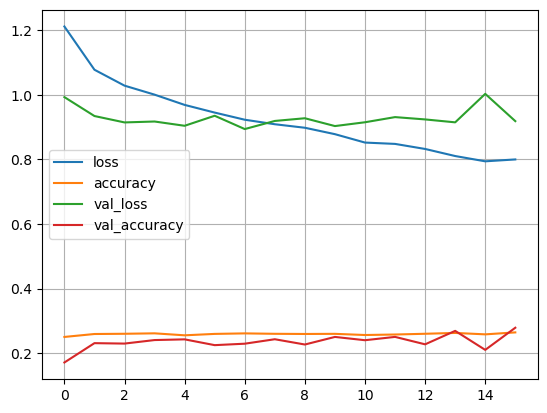

In [24]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=16,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.5, 3: 1.0},
)
plot_hist(history)

516/516 [==============================] - 68s 132ms/step


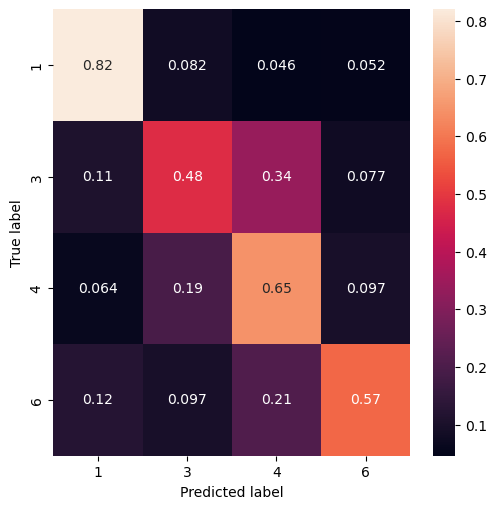

In [25]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

Conclusions: <br>
Surprise went down a little but 3 and 6 improved. Maybe tune a little bit the weight? <br>
The number of epochs seem to have an impact in the model and increasing it might have a bigger impact. <br>

## Model 3

In [60]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Define the hyperparameters
hyperparameters = {
    "learning_rate": 0.001,
    "batch_size": 32,
    "num_layers": 2,
    "num_units": 1024,
    "dropout_rate": 0.2
}

# Create a new model on top of the base model
model = Sequential()

# Add the input Rescaling layer
model.add(Rescaling(1./255, input_shape=input_shape))

# Add the base model
model.add(base_model)

# Add GlobalAveragePooling2D layer
model.add(GlobalAveragePooling2D())

# Add the dense layers
for _ in range(hyperparameters["num_layers"]):
    model.add(Dense(hyperparameters["num_units"], activation='relu'))
    model.add(tf.keras.layers.Dropout(hyperparameters["dropout_rate"]))

# Add the output layer
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparameters["learning_rate"]),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Save the model
model.save('Optimized_model3.h5', save_format='h5')
# Print the model summary
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_23 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_22  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_42 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_20 (Dropout)        (None, 1024)              0         
                                                                 
 dense_43 (Dense)            (None, 1024)            

Epoch 1/12
1204/1204 [==============================] - 244s 202ms/step - loss: 1.1776 - accuracy: 0.2517 - val_loss: 0.9431 - val_accuracy: 0.2073
Epoch 2/12
1204/1204 [==============================] - 245s 203ms/step - loss: 1.0403 - accuracy: 0.2545 - val_loss: 0.9242 - val_accuracy: 0.1916
Epoch 3/12
1204/1204 [==============================] - 242s 201ms/step - loss: 0.9883 - accuracy: 0.2534 - val_loss: 0.9073 - val_accuracy: 0.2211
Epoch 4/12
1204/1204 [==============================] - 243s 202ms/step - loss: 0.9578 - accuracy: 0.2539 - val_loss: 0.9089 - val_accuracy: 0.2211
Epoch 5/12
1204/1204 [==============================] - 243s 202ms/step - loss: 0.9248 - accuracy: 0.2566 - val_loss: 0.9092 - val_accuracy: 0.2289
Epoch 6/12
1204/1204 [==============================] - 242s 201ms/step - loss: 0.8965 - accuracy: 0.2544 - val_loss: 0.8999 - val_accuracy: 0.2312
Epoch 7/12
1204/1204 [==============================] - 242s 201ms/step - loss: 0.8744 - accuracy: 0.2532 - val_

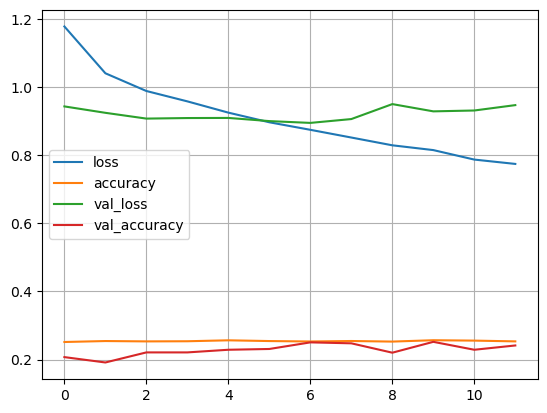

In [61]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.5, 3: 1.0},
)
plot_hist(history)

516/516 [==============================] - 79s 152ms/step


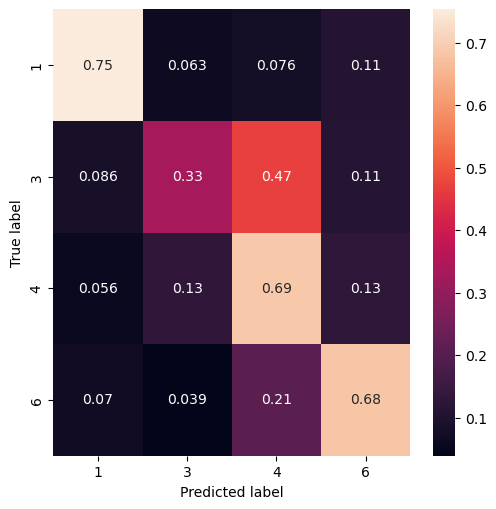

In [62]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# TEST: OVERFITTED

In [72]:
# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)

# Add additional convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

# Add additional Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_26 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          589888    
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d_25  (None, 64)             

Epoch 1/12
1204/1204 [==============================] - 253s 209ms/step - loss: 1.0619 - accuracy: 0.5283 - val_loss: 0.8968 - val_accuracy: 0.6010
Epoch 2/12
1204/1204 [==============================] - 244s 202ms/step - loss: 0.8811 - accuracy: 0.6252 - val_loss: 0.9020 - val_accuracy: 0.6158
Epoch 3/12
1204/1204 [==============================] - 243s 202ms/step - loss: 0.7999 - accuracy: 0.6683 - val_loss: 0.8882 - val_accuracy: 0.6290
Epoch 4/12
1204/1204 [==============================] - 243s 202ms/step - loss: 0.7193 - accuracy: 0.7079 - val_loss: 0.9382 - val_accuracy: 0.6430
Epoch 5/12
1204/1204 [==============================] - 243s 202ms/step - loss: 0.6438 - accuracy: 0.7371 - val_loss: 0.9805 - val_accuracy: 0.6301
Epoch 6/12
1204/1204 [==============================] - 244s 203ms/step - loss: 0.5764 - accuracy: 0.7713 - val_loss: 1.0420 - val_accuracy: 0.6285
Epoch 7/12
1204/1204 [==============================] - 242s 201ms/step - loss: 0.5172 - accuracy: 0.8010 - val_

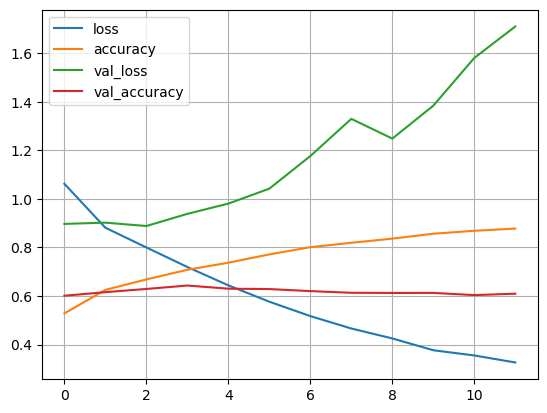

516/516 [==============================] - 112s 217ms/step - loss: 1.7098 - accuracy: 0.6095
Validation Loss: 1.7098342180252075
Validation Accuracy: 0.609475314617157


In [73]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Define the number of epochs and batch size
epochs = 12
batch_size = 32

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 116s 224ms/step


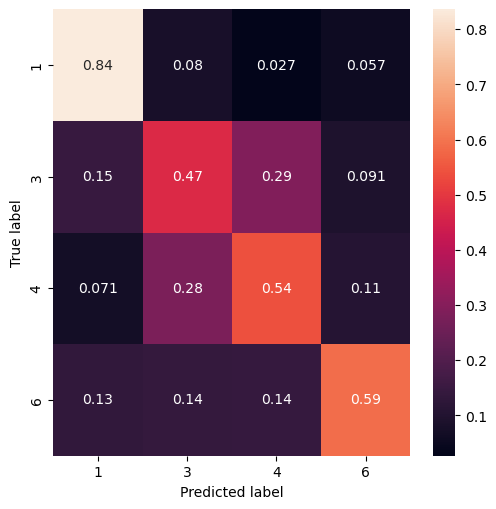

In [74]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# TEST 2 - DROPOUT TEST

In [75]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling, Dropout, Conv2D, MaxPooling2D

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)

# Add additional convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

# Add additional Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_27 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          589888    
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d_26  (None, 64)             

Epoch 1/12
1204/1204 [==============================] - 375s 311ms/step - loss: 1.0530 - accuracy: 0.5302 - val_loss: 0.9017 - val_accuracy: 0.6073
Epoch 2/12
1204/1204 [==============================] - 368s 306ms/step - loss: 0.8794 - accuracy: 0.6250 - val_loss: 0.8679 - val_accuracy: 0.6250
Epoch 3/12
1204/1204 [==============================] - 372s 309ms/step - loss: 0.8049 - accuracy: 0.6572 - val_loss: 0.8857 - val_accuracy: 0.6286
Epoch 4/12
1204/1204 [==============================] - 371s 308ms/step - loss: 0.7394 - accuracy: 0.6897 - val_loss: 0.9309 - val_accuracy: 0.6232
Epoch 5/12
1204/1204 [==============================] - 370s 307ms/step - loss: 0.6802 - accuracy: 0.7183 - val_loss: 0.9559 - val_accuracy: 0.6319
Epoch 6/12
1204/1204 [==============================] - 368s 305ms/step - loss: 0.6312 - accuracy: 0.7435 - val_loss: 0.9700 - val_accuracy: 0.6342
Epoch 7/12
1204/1204 [==============================] - 364s 302ms/step - loss: 0.5781 - accuracy: 0.7677 - val_

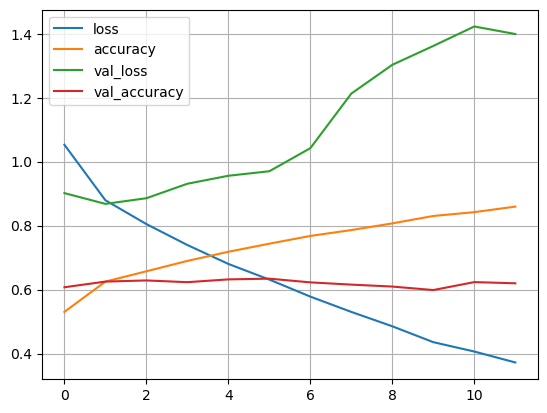

516/516 [==============================] - 105s 204ms/step - loss: 1.3990 - accuracy: 0.6197
Validation Loss: 1.39902925491333
Validation Accuracy: 0.6196534633636475


In [76]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Define the number of epochs and batch size
epochs = 12
batch_size = 32

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 106s 206ms/step


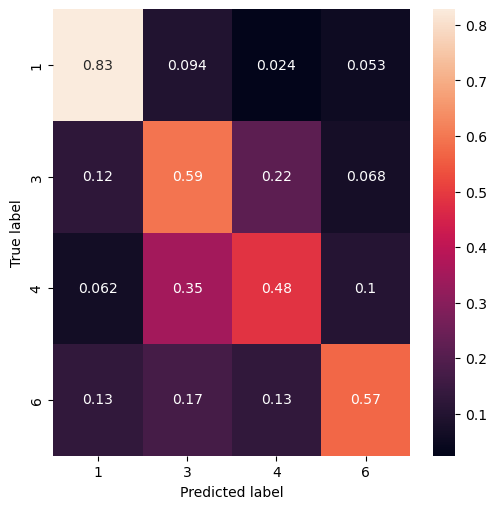

In [77]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# Test 3 - STILL OVERFITTING

In [79]:
#IMPORT L2 REGULARIZATION
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)

# Add additional convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

# Add additional Dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_29 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          589888    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 64)       

Epoch 1/14
1204/1204 [==============================] - 352s 291ms/step - loss: 2.0062 - accuracy: 0.5349 - val_loss: 1.2930 - val_accuracy: 0.5638
Epoch 2/14
1204/1204 [==============================] - 358s 298ms/step - loss: 1.2381 - accuracy: 0.5768 - val_loss: 1.3976 - val_accuracy: 0.4656
Epoch 3/14
1204/1204 [==============================] - 341s 283ms/step - loss: 1.1743 - accuracy: 0.5819 - val_loss: 1.2017 - val_accuracy: 0.5479
Epoch 4/14
1204/1204 [==============================] - 340s 283ms/step - loss: 1.1411 - accuracy: 0.5759 - val_loss: 1.1634 - val_accuracy: 0.5528
Epoch 5/14
1204/1204 [==============================] - 340s 282ms/step - loss: 1.1130 - accuracy: 0.5818 - val_loss: 1.2061 - val_accuracy: 0.5356
Epoch 6/14
1204/1204 [==============================] - 340s 283ms/step - loss: 1.1007 - accuracy: 0.5904 - val_loss: 1.1910 - val_accuracy: 0.5407
Epoch 7/14
1204/1204 [==============================] - 341s 283ms/step - loss: 1.0870 - accuracy: 0.5894 - val_

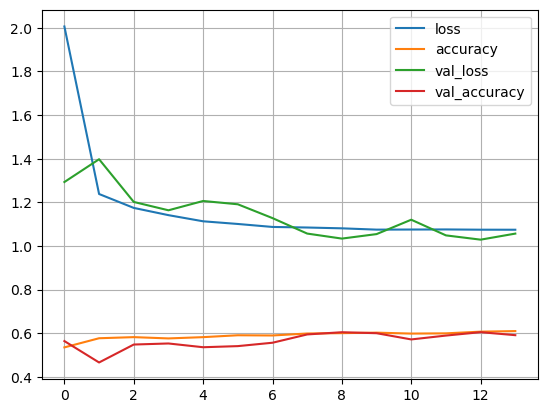

516/516 [==============================] - 98s 189ms/step - loss: 1.0565 - accuracy: 0.5908
Validation Loss: 1.05653977394104
Validation Accuracy: 0.5908154845237732


In [80]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Define the number of epochs and batch size
epochs = 14
batch_size = 32

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 97s 188ms/step


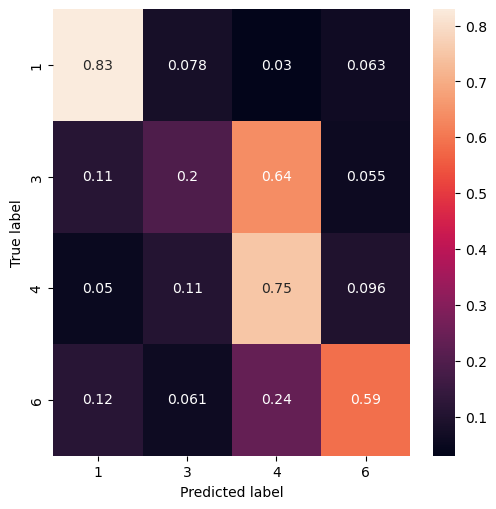

In [81]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# TEST: IMPROVE ACCURACY

In [98]:
#IMPORT L2 REGULARIZATION
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)

# Add additional convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

# Add additional Dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_35 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 64)          589888    
                                                                 
 batch_normalization_12 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 batch_normalization_13 (Bat  (None, 7, 7, 64)       

Epoch 1/14
1204/1204 [==============================] - 266s 220ms/step - loss: 2.2906 - accuracy: 0.5282 - val_loss: 1.4572 - val_accuracy: 0.5159
Epoch 2/14
1204/1204 [==============================] - 265s 220ms/step - loss: 1.4717 - accuracy: 0.5773 - val_loss: 1.4168 - val_accuracy: 0.4900
Epoch 3/14
1204/1204 [==============================] - 264s 219ms/step - loss: 1.3941 - accuracy: 0.5868 - val_loss: 1.2923 - val_accuracy: 0.5164
Epoch 4/14
1204/1204 [==============================] - 263s 219ms/step - loss: 1.3529 - accuracy: 0.6042 - val_loss: 1.2049 - val_accuracy: 0.5417
Epoch 5/14
1204/1204 [==============================] - 262s 218ms/step - loss: 1.3339 - accuracy: 0.6089 - val_loss: 1.1405 - val_accuracy: 0.5822
Epoch 6/14
1204/1204 [==============================] - 263s 218ms/step - loss: 1.3145 - accuracy: 0.6116 - val_loss: 1.2961 - val_accuracy: 0.4998
Epoch 7/14
1204/1204 [==============================] - 262s 218ms/step - loss: 1.3085 - accuracy: 0.6152 - val_

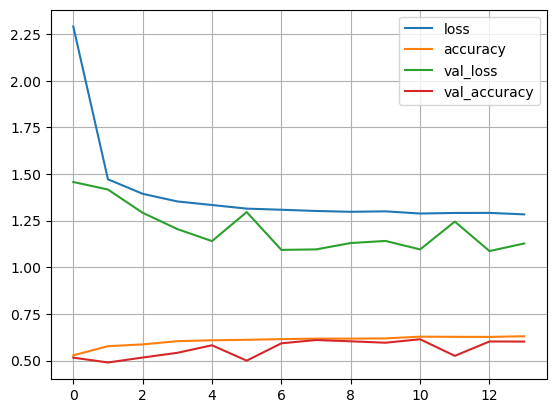

516/516 [==============================] - 68s 131ms/step - loss: 1.1277 - accuracy: 0.6021
Validation Loss: 1.1277282238006592
Validation Accuracy: 0.6020841002464294


In [99]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Define the number of epochs and batch size
epochs = 14
batch_size = 32

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.15, 2: 1.4, 3: 1.2},
)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 68s 131ms/step


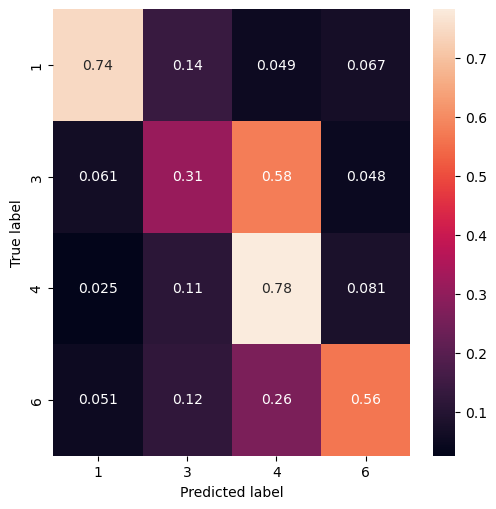

In [100]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# Base Model: Tuned
A pesar de haber utilizado gridsearch, hacer la arquitectura mas compleja y probar diferentes pesos, los resultados no mejoran y en algunos casos, empeoran. Por lo que voy a volver a la arquitectura basica y empezar a tunearla a partir de ahi.

In [83]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))  # Additional Dense layer
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 3,492,292
Trainable params: 263,428
Non-

In [85]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)

Epoch 1/12
1204/1204 [==============================] - 310s 258ms/step - loss: 0.9800 - accuracy: 0.5838 - val_loss: 0.9046 - val_accuracy: 0.6164
Epoch 2/12
1204/1204 [==============================] - 318s 264ms/step - loss: 0.8687 - accuracy: 0.6398 - val_loss: 0.8751 - val_accuracy: 0.6314
Epoch 3/12
1204/1204 [==============================] - 297s 247ms/step - loss: 0.8147 - accuracy: 0.6635 - val_loss: 0.8752 - val_accuracy: 0.6365
Epoch 4/12
1204/1204 [==============================] - 293s 243ms/step - loss: 0.7682 - accuracy: 0.6870 - val_loss: 0.8781 - val_accuracy: 0.6383
Epoch 5/12
1204/1204 [==============================] - 299s 249ms/step - loss: 0.7268 - accuracy: 0.7025 - val_loss: 0.9000 - val_accuracy: 0.6360
Epoch 6/12
1204/1204 [==============================] - 292s 243ms/step - loss: 0.6805 - accuracy: 0.7246 - val_loss: 0.9188 - val_accuracy: 0.6335
Epoch 7/12
1204/1204 [==============================] - 288s 239ms/step - loss: 0.6333 - accuracy: 0.7458 - val_

516/516 [==============================] - 115s 223ms/step


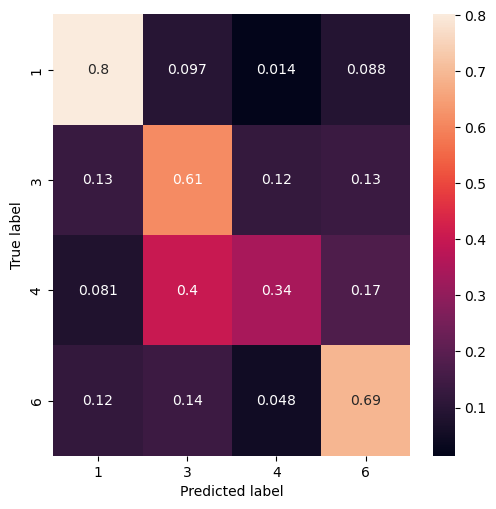

In [86]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# Base Model: Tuned 2

In [45]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu')) 
model.add(Dense(128, activation='relu')) # Additional Dense layer
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_15  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_35 (Dense)            (None, 256)               262400    
                                                                 
 dense_36 (Dense)            (None, 128)               32896     
                                                                 
 dense_37 (Dense)            (None, 4)               

Epoch 1/14
1204/1204 [==============================] - 243s 201ms/step - loss: 0.9243 - accuracy: 0.6049 - val_loss: 0.9155 - val_accuracy: 0.6132
Epoch 2/14
1204/1204 [==============================] - 248s 206ms/step - loss: 0.8546 - accuracy: 0.6430 - val_loss: 0.9747 - val_accuracy: 0.6043
Epoch 3/14
1204/1204 [==============================] - 246s 204ms/step - loss: 0.8109 - accuracy: 0.6645 - val_loss: 0.8974 - val_accuracy: 0.6275
Epoch 4/14
1204/1204 [==============================] - 246s 205ms/step - loss: 0.7711 - accuracy: 0.6840 - val_loss: 0.9187 - val_accuracy: 0.6237
Epoch 5/14
1204/1204 [==============================] - 247s 205ms/step - loss: 0.7321 - accuracy: 0.6996 - val_loss: 1.0476 - val_accuracy: 0.5952
Epoch 6/14
1204/1204 [==============================] - 246s 204ms/step - loss: 0.7016 - accuracy: 0.7146 - val_loss: 0.9447 - val_accuracy: 0.6255
Epoch 7/14
1204/1204 [==============================] - 245s 204ms/step - loss: 0.6580 - accuracy: 0.7317 - val_

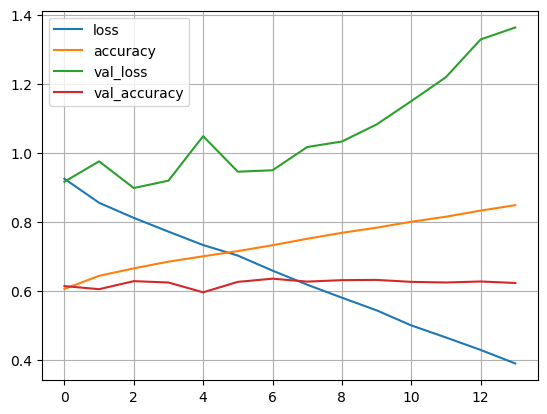

516/516 [==============================] - 74s 142ms/step - loss: 1.3626 - accuracy: 0.6222
Validation Loss: 1.3625963926315308
Validation Accuracy: 0.6221979856491089


In [47]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Define the number of epochs and batch size
epochs = 14
batch_size = 32

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 76s 146ms/step


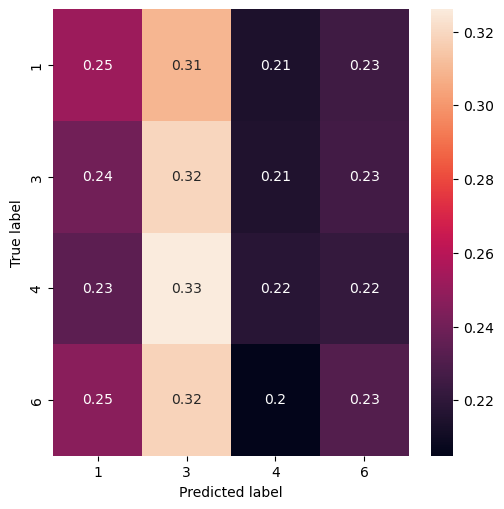

In [48]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# Mas capas densas

In [49]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu')) 
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))# Additional Dense layer
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_16  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_38 (Dense)            (None, 256)               262400    
                                                                 
 dense_39 (Dense)            (None, 128)               32896     
                                                                 
 dense_40 (Dense)            (None, 64)              

Epoch 1/14
1204/1204 [==============================] - 300s 248ms/step - loss: 0.9978 - accuracy: 0.5665 - val_loss: 0.9124 - val_accuracy: 0.6132
Epoch 2/14
1204/1204 [==============================] - 277s 230ms/step - loss: 0.8772 - accuracy: 0.6317 - val_loss: 0.9398 - val_accuracy: 0.5833
Epoch 3/14
1204/1204 [==============================] - 279s 232ms/step - loss: 0.8310 - accuracy: 0.6550 - val_loss: 0.8811 - val_accuracy: 0.6283
Epoch 4/14
1204/1204 [==============================] - 279s 231ms/step - loss: 0.7896 - accuracy: 0.6741 - val_loss: 0.9260 - val_accuracy: 0.6131
Epoch 5/14
1204/1204 [==============================] - 278s 231ms/step - loss: 0.7517 - accuracy: 0.6895 - val_loss: 0.9163 - val_accuracy: 0.6325
Epoch 6/14
1204/1204 [==============================] - 279s 231ms/step - loss: 0.7086 - accuracy: 0.7082 - val_loss: 0.9342 - val_accuracy: 0.6308
Epoch 7/14
1204/1204 [==============================] - 278s 231ms/step - loss: 0.6739 - accuracy: 0.7271 - val_

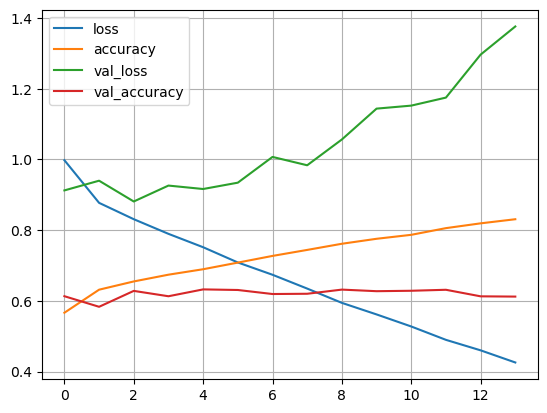

516/516 [==============================] - 82s 159ms/step - loss: 1.3759 - accuracy: 0.6121
Validation Loss: 1.375908374786377
Validation Accuracy: 0.6121410131454468


In [50]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Define the number of epochs and batch size
epochs = 14
batch_size = 32

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 83s 160ms/step


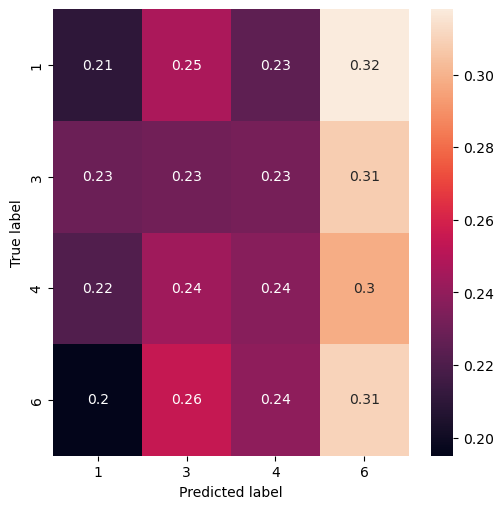

In [51]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# Menos batch size

In [52]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu')) 
model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))# Additional Dense layer
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_17  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_42 (Dense)            (None, 256)               262400    
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dense_44 (Dense)            (None, 4)               

Epoch 1/14
1204/1204 [==============================] - 306s 254ms/step - loss: 1.0054 - accuracy: 0.5653 - val_loss: 0.9217 - val_accuracy: 0.5987
Epoch 2/14
1204/1204 [==============================] - 301s 250ms/step - loss: 0.8835 - accuracy: 0.6271 - val_loss: 0.8802 - val_accuracy: 0.6304
Epoch 3/14
1204/1204 [==============================] - 302s 251ms/step - loss: 0.8242 - accuracy: 0.6587 - val_loss: 0.8937 - val_accuracy: 0.6190
Epoch 4/14
1204/1204 [==============================] - 302s 251ms/step - loss: 0.7872 - accuracy: 0.6759 - val_loss: 0.8657 - val_accuracy: 0.6421
Epoch 5/14
1204/1204 [==============================] - 302s 251ms/step - loss: 0.7502 - accuracy: 0.6893 - val_loss: 0.8996 - val_accuracy: 0.6329
Epoch 6/14
1204/1204 [==============================] - 302s 251ms/step - loss: 0.7072 - accuracy: 0.7092 - val_loss: 0.8922 - val_accuracy: 0.6300
Epoch 7/14
1204/1204 [==============================] - 302s 251ms/step - loss: 0.6689 - accuracy: 0.7259 - val_

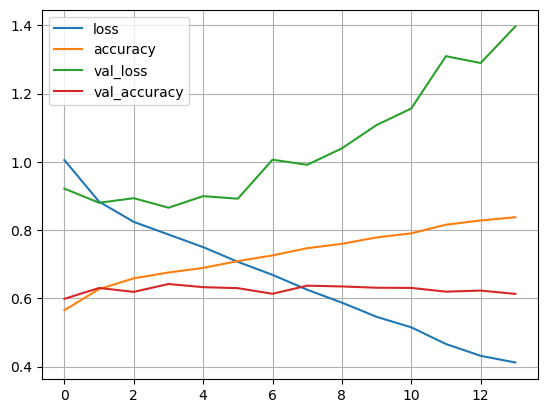

516/516 [==============================] - 90s 175ms/step - loss: 1.3970 - accuracy: 0.6131
Validation Loss: 1.3969769477844238
Validation Accuracy: 0.613110363483429


In [53]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Define the number of epochs and batch size
epochs = 14
batch_size = 16

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 88s 170ms/step


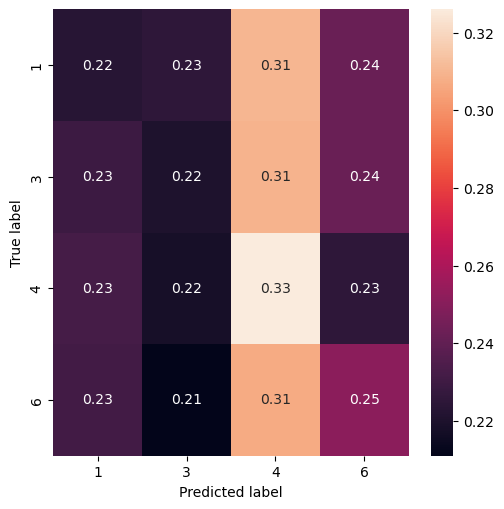

In [54]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# Mas capas, menos batch size

In [55]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu')) 
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))# Additional Dense layer
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_18  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_45 (Dense)            (None, 256)               262400    
                                                                 
 dense_46 (Dense)            (None, 128)               32896     
                                                                 
 dense_47 (Dense)            (None, 64)              

Epoch 1/14
1204/1204 [==============================] - 294s 244ms/step - loss: 1.0059 - accuracy: 0.5665 - val_loss: 0.9198 - val_accuracy: 0.6090
Epoch 2/14
1204/1204 [==============================] - 288s 240ms/step - loss: 0.8794 - accuracy: 0.6340 - val_loss: 0.8917 - val_accuracy: 0.6226
Epoch 3/14
1204/1204 [==============================] - 288s 239ms/step - loss: 0.8325 - accuracy: 0.6547 - val_loss: 0.8681 - val_accuracy: 0.6346
Epoch 4/14
1204/1204 [==============================] - 291s 241ms/step - loss: 0.7904 - accuracy: 0.6761 - val_loss: 0.9125 - val_accuracy: 0.6285
Epoch 5/14
1204/1204 [==============================] - 290s 241ms/step - loss: 0.7548 - accuracy: 0.6908 - val_loss: 0.8725 - val_accuracy: 0.6384
Epoch 6/14
1204/1204 [==============================] - 290s 241ms/step - loss: 0.7155 - accuracy: 0.7079 - val_loss: 0.9118 - val_accuracy: 0.6333
Epoch 7/14
1204/1204 [==============================] - 290s 240ms/step - loss: 0.6813 - accuracy: 0.7232 - val_

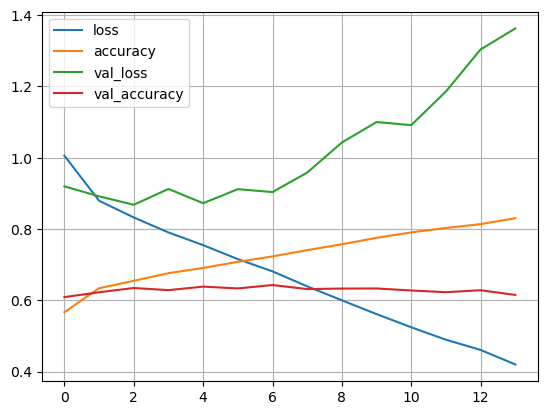

516/516 [==============================] - 85s 165ms/step - loss: 1.3627 - accuracy: 0.6152
Validation Loss: 1.3627182245254517
Validation Accuracy: 0.6151702404022217


In [56]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Define the number of epochs and batch size
epochs = 14
batch_size = 16

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 77s 149ms/step


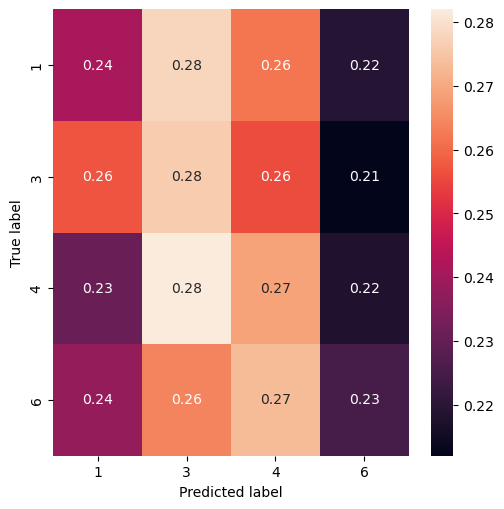

In [57]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# simple test please work lol

In [66]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_23 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_22  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_52 (Dense)            (None, 4)                 4100      
                                                                 
Total params: 3,232,964
Trainable params: 4,100
Non-trainable params: 3,228,864
_________________________________________________________________


Epoch 1/12
1204/1204 [==============================] - 318s 264ms/step - loss: 1.0335 - accuracy: 0.5575 - val_loss: 0.9585 - val_accuracy: 0.5957
Epoch 2/12
1204/1204 [==============================] - 308s 256ms/step - loss: 0.8952 - accuracy: 0.6247 - val_loss: 0.8927 - val_accuracy: 0.6284
Epoch 3/12
1204/1204 [==============================] - 316s 263ms/step - loss: 0.8572 - accuracy: 0.6443 - val_loss: 0.9517 - val_accuracy: 0.6017
Epoch 4/12
1204/1204 [==============================] - 317s 263ms/step - loss: 0.8347 - accuracy: 0.6574 - val_loss: 0.8877 - val_accuracy: 0.6344
Epoch 5/12
1204/1204 [==============================] - 329s 273ms/step - loss: 0.8217 - accuracy: 0.6601 - val_loss: 0.8970 - val_accuracy: 0.6269
Epoch 6/12
1204/1204 [==============================] - 329s 273ms/step - loss: 0.8121 - accuracy: 0.6665 - val_loss: 0.8880 - val_accuracy: 0.6329
Epoch 7/12
1204/1204 [==============================] - 331s 275ms/step - loss: 0.8087 - accuracy: 0.6669 - val_

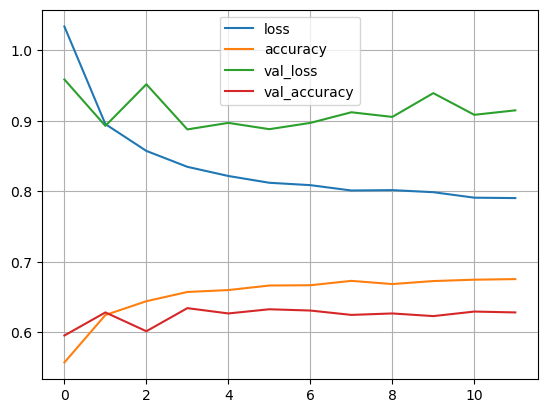

516/516 [==============================] - 96s 185ms/step - loss: 0.9147 - accuracy: 0.6284
Validation Loss: 0.9147204160690308
Validation Accuracy: 0.6283775568008423


In [69]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    batch_size=16,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)

plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

516/516 [==============================] - 97s 188ms/step


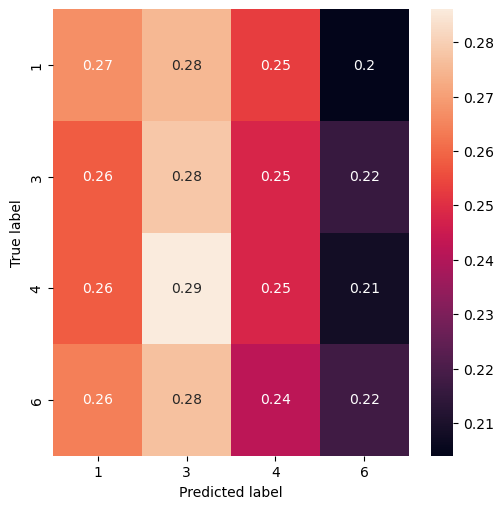

In [70]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

# TEST CON 3 EMOCIONES

In [71]:
import pathlib

data_dir = 'C:/Users/micha/OneDrive/Desktop/U/TFM/Data3'

data_dir = pathlib.Path(data_dir)
print(data_dir)
print(type(data_dir))

C:\Users\micha\OneDrive\Desktop\U\TFM\Data3
<class 'pathlib.WindowsPath'>


In [72]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    color_mode="rgb",
    seed=0,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(type(train_ds))

Found 20634 files belonging to 3 classes.
Using 14444 files for training.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [73]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    color_mode="rgb",
    seed=0,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(type(val_ds))

Found 20634 files belonging to 3 classes.
Using 6190 files for validation.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [74]:
class_names = train_ds.class_names
print(class_names)

['1', '4', '6']


In [75]:
#IMPORT L2 REGULARIZATION
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)

# Add additional convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

# Add additional Dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_24 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          589888    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 64)       

Epoch 1/14
903/903 [==============================] - 300s 331ms/step - loss: 1.8386 - accuracy: 0.6960 - val_loss: 1.0680 - val_accuracy: 0.6814
Epoch 2/14
903/903 [==============================] - 279s 309ms/step - loss: 0.9444 - accuracy: 0.7318 - val_loss: 0.8797 - val_accuracy: 0.7191
Epoch 3/14
903/903 [==============================] - 280s 311ms/step - loss: 0.8552 - accuracy: 0.7462 - val_loss: 0.9309 - val_accuracy: 0.7026
Epoch 4/14
903/903 [==============================] - 277s 307ms/step - loss: 0.8299 - accuracy: 0.7504 - val_loss: 0.7719 - val_accuracy: 0.7682
Epoch 5/14
903/903 [==============================] - 276s 306ms/step - loss: 0.7914 - accuracy: 0.7624 - val_loss: 0.9115 - val_accuracy: 0.7121
Epoch 6/14
903/903 [==============================] - 275s 304ms/step - loss: 0.7790 - accuracy: 0.7665 - val_loss: 0.7760 - val_accuracy: 0.7609
Epoch 7/14
903/903 [==============================] - 273s 302ms/step - loss: 0.7687 - accuracy: 0.7689 - val_loss: 0.7487 -

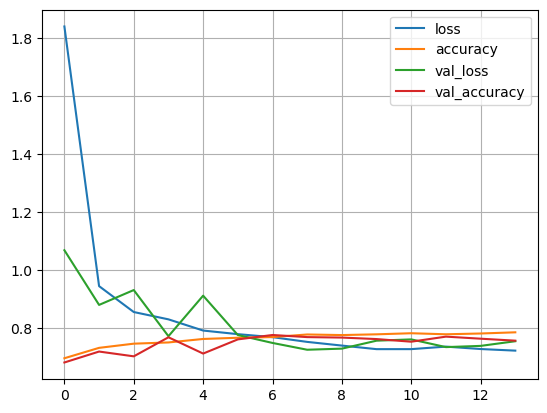

387/387 [==============================] - 76s 196ms/step - loss: 0.7546 - accuracy: 0.7565
Validation Loss: 0.7546221017837524
Validation Accuracy: 0.7565428018569946


In [76]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Define the number of epochs and batch size
epochs = 14
batch_size = 32

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

387/387 [==============================] - 76s 196ms/step


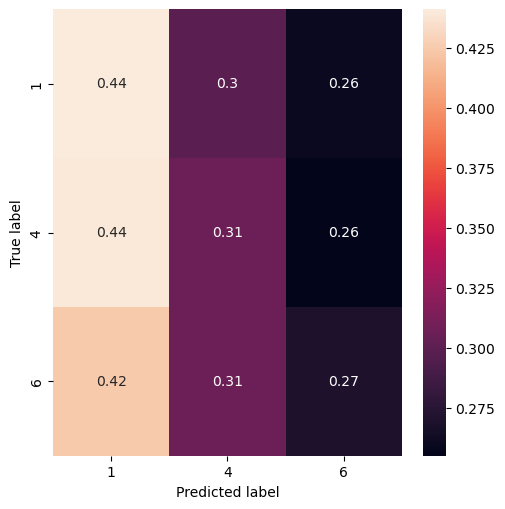

In [77]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)

In [78]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Rescaling

# Define the input shape
input_shape = (224, 224, 3)  # RGB images of size 224x224

# Create the base MobileNet model
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(3, activation='softmax'))  # 4 classes for emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_25 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_24  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_56 (Dense)            (None, 3)                 3075      
                                                                 
Total params: 3,231,939
Trainable params: 3,075
Non-trainable params: 3,228,864
_________________________________________________________________


In [80]:
# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_ds.cardinality().numpy()
val_steps_per_epoch = val_ds.cardinality().numpy()

# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0},
)

Epoch 1/10
903/903 [==============================] - 225s 248ms/step - loss: 0.7333 - accuracy: 0.6816 - val_loss: 0.7133 - val_accuracy: 0.7000
Epoch 2/10
903/903 [==============================] - 223s 246ms/step - loss: 0.5969 - accuracy: 0.7539 - val_loss: 0.5994 - val_accuracy: 0.7528
Epoch 3/10
903/903 [==============================] - 222s 246ms/step - loss: 0.5631 - accuracy: 0.7671 - val_loss: 0.5913 - val_accuracy: 0.7562
Epoch 4/10
903/903 [==============================] - 217s 240ms/step - loss: 0.5434 - accuracy: 0.7791 - val_loss: 0.5975 - val_accuracy: 0.7583
Epoch 5/10
903/903 [==============================] - 212s 235ms/step - loss: 0.5294 - accuracy: 0.7866 - val_loss: 0.5810 - val_accuracy: 0.7666
Epoch 6/10
903/903 [==============================] - 212s 234ms/step - loss: 0.5236 - accuracy: 0.7883 - val_loss: 0.6009 - val_accuracy: 0.7569
Epoch 7/10
903/903 [==============================] - 211s 234ms/step - loss: 0.5183 - accuracy: 0.7899 - val_loss: 0.5897 -

387/387 [==============================] - 65s 168ms/step


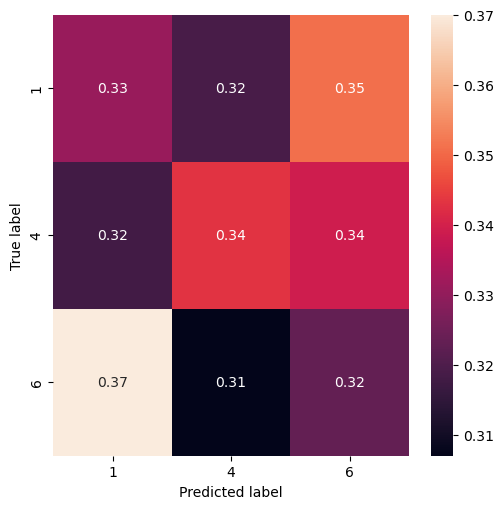

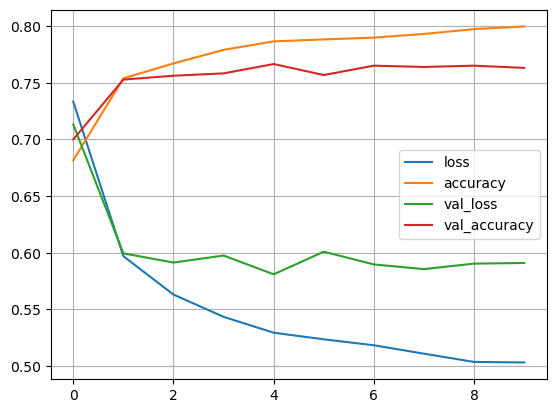

387/387 [==============================] - 89s 231ms/step - loss: 0.5910 - accuracy: 0.7632
Validation Loss: 0.5909543037414551
Validation Accuracy: 0.7631663680076599


In [81]:
val_ds_labels = get_labels_from_tfdataset(val_ds).numpy()
val_pred = np.argmax(model.predict(val_ds), axis=-1)

plot_confussion_matrix(labels = val_ds_labels
                   , predictions = val_pred
                   , classes = class_names, figsize = 5)
plot_hist(history)
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# Production

In [84]:
import cv2
import tensorflow as tf

# Load the optimized model
model = tf.keras.models.load_model('C:/Users/micha/OneDrive/Desktop/U/TFM/Saved Models/Optimized_model.h5')

# Initialize the face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize the camera
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check if the frame is valid
    if not ret or frame is None:
        continue

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Iterate over detected faces
    for (x, y, w, h) in faces:
        # Extract the face region of interest (ROI)
        face_roi = frame[y:y+h, x:x+w]

        # Resize the face ROI to the desired size
        resized_face = cv2.resize(face_roi, (224, 224))

        # Preprocess the resized face image
        preprocessed_face = resized_face / 255.0

        # Expand dimensions to match the model input shape
        preprocessed_face = tf.expand_dims(preprocessed_face, axis=0)

        # Perform emotion prediction on the preprocessed face using the loaded model
        predictions = model.predict(preprocessed_face)
        emotion_label = ['Angry', 'Happy', 'Sad', 'Neutral'][tf.argmax(predictions[0])]

        # Draw the emotion label on the frame
        cv2.putText(frame, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Emotion Recognition', frame)

    # Check for 'q' key to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


KeyboardInterrupt: 